# Init

In [15]:
!pip install transformers
import time
import torch
import random
import datetime
import numpy as np
import pandas as pd
import transformers
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score,accuracy_score
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# % matplotlib inline


In [16]:
device=torch.device("cuda")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Dataset


In [17]:
df_train = pd.read_csv("https://raw.githubusercontent.com/google-research-datasets/query-wellformedness/master/train.tsv", delimiter='\t', header=None, names=['text', 'val'])
df_test = pd.read_csv("https://raw.githubusercontent.com/google-research-datasets/query-wellformedness/master/test.tsv", delimiter='\t', header=None, names=['text', 'val'])
df_dev = pd.read_csv("https://raw.githubusercontent.com/google-research-datasets/query-wellformedness/master/dev.tsv", delimiter='\t', header=None, names=['text', 'val'])

train_text=df_train["text"]
train_val=df_train["val"]
test_text=df_test["text"]
test_val=df_test["val"]
val_text=df_dev["text"]
val_val=df_dev["val"]

for i in range(len(train_val)):
  if(train_val[i]>=0.8):
    train_val[i]=1
  else:
    train_val[i]=0
for i in range(len(test_val)):
  if(test_val[i]>=0.8):
    test_val[i]=1
  else:
    test_val[i]=0
for i in range(len(val_val)):
  if(val_val[i]>=0.8):
    val_val[i]=1
  else:
    val_val[i]=0
train_val = train_val.astype(int)
test_val = test_val.astype(int)
val_val = val_val.astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyW

# Tokenization



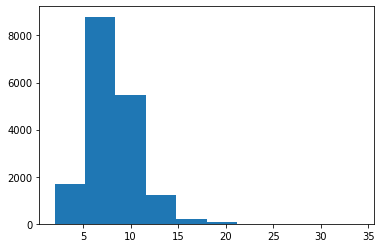

In [18]:
seq_len = [len(i.split()) for i in train_text]
plt.hist(seq_len)
plt.show()

In [19]:
max_len_to_pad = 25

In [20]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.to_list(),
    max_length=max_len_to_pad,
    pad_to_max_length=True,
    truncation=True
)
train_seq = torch.tensor(tokens_train["input_ids"])
train_mask = torch.tensor(tokens_train["attention_mask"])
train_y = torch.tensor(train_val.to_list())

tokens_test = tokenizer.batch_encode_plus(
    test_text.to_list(),
    max_length=max_len_to_pad,
    pad_to_max_length=True,
    truncation=True
)
test_seq = torch.tensor(tokens_test["input_ids"])
test_mask = torch.tensor(tokens_test["attention_mask"])
test_y = torch.tensor(test_val.to_list())

tokens_val = tokenizer.batch_encode_plus(
    val_text.to_list(),
    max_length=max_len_to_pad,
    pad_to_max_length=True,
    truncation=True
)
val_seq = torch.tensor(tokens_val["input_ids"])
val_mask = torch.tensor(tokens_val["attention_mask"])
val_y = torch.tensor(val_val.to_list())

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [21]:
batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(val_seq, val_mask, val_y)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Model Training

In [22]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()
optimizer = AdamW(model.parameters(),lr = 1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [24]:
seed_val = 7
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
for epoch_i in range(0, epochs):
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

print("Ureka!")

Ureka!


# Model Testing


In [25]:
prediction_data = TensorDataset(test_seq, test_mask, test_y)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [26]:
model.eval()
predictions , true_labels = [], []
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

In [27]:
pre = []
tru = [] 
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  for j in range(len(true_labels[i])):
    pre.append(pred_labels_i[j])
    tru.append(true_labels[i][j])
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC Score: %.3f' % mcc)
print('F1 Score: %.3f' % f1_score(tru, pre))
print('Accuracy Score: %.3f' % accuracy_score(tru, pre))

MCC Score: 0.635
F1 Score: 0.784
Accuracy Score: 0.811


# Analysis

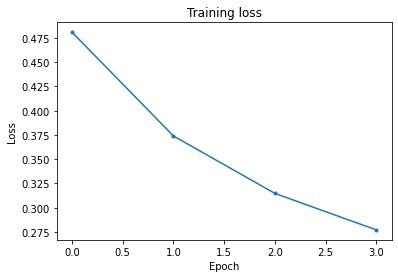

In [28]:
plt.plot(loss_values,marker=".")
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()